In [1]:
using ApproxFun
using ApproxFunBase
using LinearAlgebra
using GenericLinearAlgebra
using Plots

In [2]:
function example6(n)
    ## test for Airy equation
    ## eps * u''(x) - x * u(x) = 0
    ## u(-1) = Ai(-sqrt3(1 / eps))
    ## u(1) = Ai(sqrt3(1 / eps))
    ## u_exact = Ai(sqrt3(1 / eps) * x);
    ## solution

    x = Fun();
    eps = 1e-9;

    ## innital date u0bound
    u0 = zeros(n , 1);

    ## diff mat D
    D = zeros(n , n);
    D[1:n, 1:n] = Derivative(Chebyshev() , 2)[1:n, 1:n];

    ## convert matrix S
    S = zeros(n , n);
    S = Conversion(Chebyshev(),Ultraspherical(2))[1:n , 1:n];

    ## multimat M
    M = zeros(n , n);
    M = Multiplication(x, Chebyshev())[1:n , 1:n];

    ## boundary conditions B
    B = zeros(2 , n);
    B = Dirichlet(-1..1)[1 : 2 , 1 : n];

    ## diff operator
    L = zeros(n , n);
    L = eps .* D  - S * M;
    L[3 : end , :] = L[1 : end - 2 , :];
    L[1 : 2 , :] = B;

    ## right hand side
    f = zeros(n , 1);
    u0 = S * u0;
    f[3 : end] = u0[1 : end - 2];
    f[1] = 0.05597189577439192;
    f[2] = 0;
    
    ## solve 
    # unum = L \ f;
    Q, R = givensQR([L f], 5);
    # unum = R \ (Q \ f);
    unum = back_substitution(R[: , 1 : end - 1], R[:,end])
    # err
    # F = qr(L);
    # unum = F.R\(F.Q \ f);
    return unum
end

example6 (generic function with 1 method)

In [3]:
function back_substitution(U, b)
    n = size(U, 1)
    x = zeros(n)
    for i = n:-1:1
        if U[i, i] == 0
            error("矩阵是奇异的，不能求解")
        end
        x[i] = b[i]
        for j = i+1:n
            x[i] -= U[i, j] * x[j]
        end
        x[i] /= U[i, i]
    end
    return x
end

function givensQR(A, k)
    m, n = size(A)
    Q = Matrix{Float64}(I, m, m)

    for i = 1:n-1
        for j = i+1:min(m, i+k)
            x = A[i:min(m, i+k), i]
            rt = givens(x, j-i+1)
            Q[:, i:min(m, i+k)] = Q[:, i:min(m, i+k)] * rt'
            A[i:min(m, i+k), :] = rt * A[i:min(m, i+k), :]
            # println("j: ", j)
        end
    end

    return Q, A
end

function givens(x, j)
    xi = x[1]
    xj = x[j]
    r = sqrt(xi^2 + xj^2)
    cost = xi / r
    sint = xj / r
    R = Matrix{Float64}(I, length(x), length(x))
    R[1, 1] = cost
    R[1, j] = sint
    R[j, 1] = -sint
    R[j, j] = cost
    return R
end

givens (generic function with 1 method)

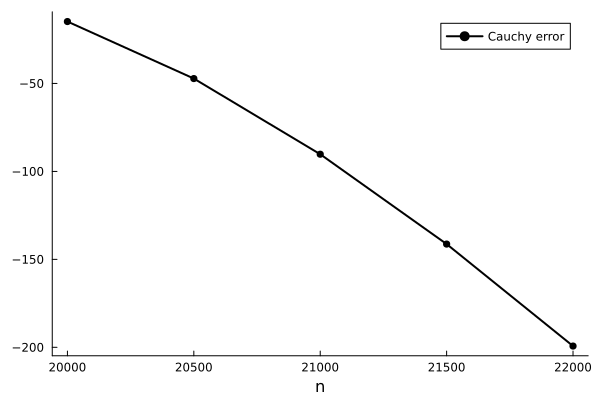

In [4]:
# Plots
x = 20000 : 500 : 22000;
lx = size(x);
global errcauchy = zeros(lx[1] , 1);
global err = zeros(lx[1] , 1);
for i = 1 : 1 : lx[1]
    u1 = example6(x[i]);
    u2 = example6(Int(ceil(1.01* x[i])));
    global errcauchy[i] = norm(u1 - u2[1 : x[i]] , 2);
end

p1 = plot(x, log10.(errcauchy), color=:black, shape=:circle, linewidth=2, xlabel="n", label=:"Cauchy error", alpha=1, grid=false)
# p2 = plot!(x, log10.(ucoe[10 : 10 : 500]), color=:black, shape=:cross, linewidth=2, label=:"coefficients of airy function", alpha=1, grid=false)
# p3 = plot!(x, log10.(err), color=:black, shape=:star4, linewidth=2, xlabel=L"n", label=:"Float64-uexact", alpha=1, grid=false)